# Build a Multi-output Model

> In this post, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data. This is the summary of lecture "Custom Models, Layers and Loss functions with Tensorflow" from DeepLearning.AI.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Coursera, Tensorflow, DeepLearining.AI]
- image: 

## Packages

In [1]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

C:\Users\kcsgo\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2

def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])

def plot_metrics(history, metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)

## Prepare the Data

We download the dataset and format it for training.

In [11]:
# Specify data URI
URI = './dataset/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the train and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [5]:
# define model layers
input_layer = Input(shape=(len(train.columns), ))
first_dense = Dense(units=128, activation='relu')(input_layer)
second_dense = Dense(units=128, activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units=1, name='y1_output')(second_dense)
third_dense = Dense(units=64, activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units=1, name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

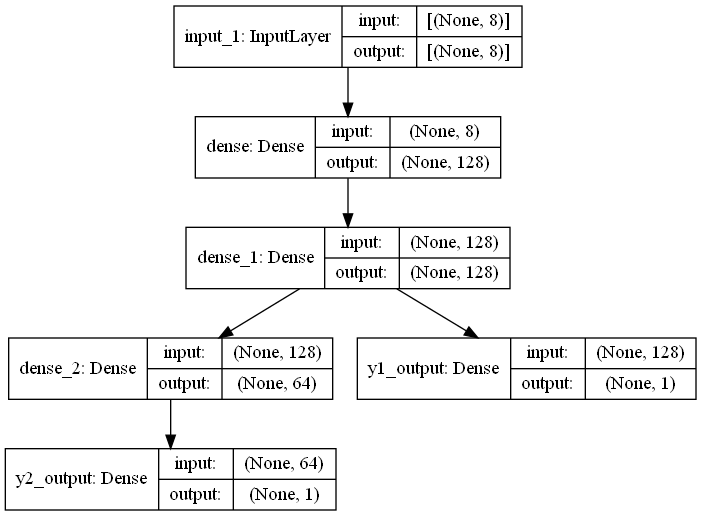

In [8]:
plot_model(model, show_shapes=True, show_layer_names=True)

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [10]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss={
                  'y1_output':'mse',
                  'y2_output':'mse'
              },
             metrics={
                 'y1_output':tf.keras.metrics.RootMeanSquaredError(),
                 'y2_output':tf.keras.metrics.RootMeanSquaredError()
             })

## Train the Model

In [12]:
# train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Epoch 1/500
62/62 [==============================] - 2s 9ms/step - loss: 204.3900 - y1_output_loss: 95.0448 - y2_output_loss: 109.3452 - y1_output_root_mean_squared_error: 9.7491 - y2_output_root_mean_squared_error: 10.4568 - val_loss: 63.2201 - val_y1_output_loss: 24.1169 - val_y2_output_loss: 39.1031 - val_y1_output_root_mean_squared_error: 4.9109 - val_y2_output_root_mean_squared_error: 6.2533
Epoch 2/500
62/62 [==============================] - 0s 7ms/step - loss: 33.1311 - y1_output_loss: 12.3411 - y2_output_loss: 20.7900 - y1_output_root_mean_squared_error: 3.5130 - y2_output_root_mean_squared_error: 4.5596 - val_loss: 36.0277 - val_y1_output_loss: 16.9359 - val_y2_output_loss: 19.0918 - val_y1_output_root_mean_squared_error: 4.1153 - val_y2_output_root_mean_squared_error: 4.3694
Epoch 3/500
62/62 [==============================] - 0s 7ms/step - loss: 22.8962 - y1_output_loss: 9.2439 - y2_output_loss: 13.6524 - y1_output_root_mean_squared_error: 3.0404 - y2_output_root_mean_squar

## Evaluate the Model and Plot Metrics

In [13]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

5/5 [==============================] - 0s 5ms/step - loss: 1.0714 - y1_output_loss: 0.3170 - y2_output_loss: 0.7544 - y1_output_root_mean_squared_error: 0.5630 - y2_output_root_mean_squared_error: 0.8686
Loss = 1.0714385509490967, Y1_loss = 0.31699976325035095, Y1_mse = 0.5630273222923279, Y2_loss = 0.7544388175010681, Y2_mse = 0.8685843348503113


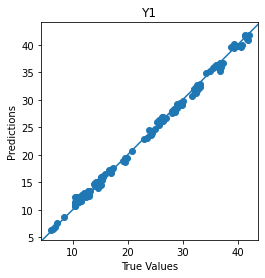

In [15]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')

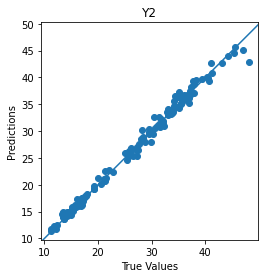

In [16]:
plot_diff(test_Y[1], Y_pred[1], title='Y2')

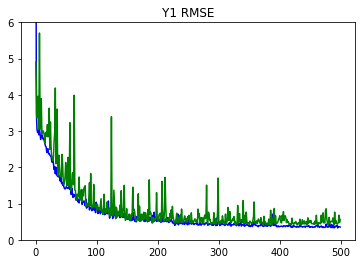

In [17]:
plot_metrics(history, metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)

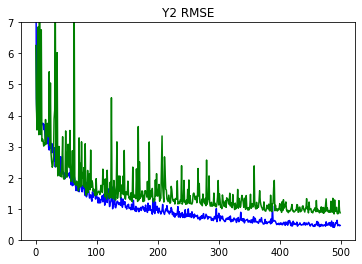

In [18]:
plot_metrics(history, metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)